# Making of the occlusion maps for the full multi-task model
In this notebook, we load the trained full multi-task model (found in the logs/ directory) and
we analyze it by making occlusion maps.

## 1. Preamble
### Load packages, define basic variables and load small custom functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score

In [ ]:
dfs = [B_F, B_W, B_WT, F_B, F_W, F_WT, W_B, W_F, W_WT]
df_names = ['B_F', 'B_W', 'B_WT', 'F_B', 'F_W', 'F_WT', 'W_B', 'W_F', 'W_WT']
device = torch.device('cuda')

In [ ]:
def one_hot_sequence(seq):
    d = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    length = len(seq)
    m = np.zeros((4, length), dtype='float32')
    
    for i, b in enumerate(seq):
        m[d[b]][i] = 1   
    return m

def outputSize(in_size, kernel_size, stride, padding):
    return int((in_size - kernel_size + 2*(padding)) / stride) + 1

def num_flat_features(x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

### Load PyTorch Dataset class

In [15]:
class Dataset_MultiLabelNeuralNet(Dataset):
    def __init__(self, X, y):
        
        self.X = X
        self.y = y
            
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = torch.from_numpy(one_hot_sequence(self.X.iloc[idx]).flatten())
        data = data.to(device, dtype=torch.float32)
        target = np.array(self.y.iloc[idx])
        target = torch.from_numpy(target).to(device, dtype=torch.float32)
        return data, target

### Load fcANN class

In [16]:
class MultiLabelNeuralNet_4HiddenLayer(nn.Module):
    def __init__(self, 
                 in_size=48, 
                 hidden_size1=96, 
                 hidden_size2=192, 
                 hidden_size3=384,
                 hidden_size4=384,
                 dropoutp1=0.2, 
                 dropoutp2=0.2,
                 dropoutp3=0.2,
                 dropoutp4=0.2,
                 out_size=9):
        super(MultiLabelNeuralNet_4HiddenLayer, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropoutp1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropoutp2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropoutp3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.dropout4 = nn.Dropout(p=dropoutp4)
        self.fc5 = nn.Linear(hidden_size4, out_size)
        
    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc4(x))))
        out = self.fc5(x)
        return out

### Load function for evaluation of the multi-task model

In [17]:
def evaluate_super_ml_on_sl(model,
                            test_loader,
                            label_no,
                            plot_metrics=True):
    '''Evaluate a PyTorch Model
    
    For evaluation, no logger object is needed because there are no epochs

    Params
    --------
        model (PyTorch model): neural network to evaluate
        test_loader (PyTorch dataloader): testing dataloader to iterate through
        label_no (int): integer to decide which column of the output should be evaluated
        plot_metrics (bool): boolean to plot metrics or not

    Returns
    --------
        None
    '''
    
    assert label_no in [0, 1, 2, 3, 4, 5, 6, 7, 8], 'label_no should be between 0 and 8'
    metrics_dict = {'output': [], 'target': []}
    model.eval()
    
    with torch.no_grad():
        
        # Testing loop
        for data, target in test_loader:
            
            # Predicted outputs
            output = model(data)
            
            # Convert from tensor to numpy array
            target = target.data.cpu().numpy()[:,label_no]
            output = output.data.cpu().numpy()[:,label_no]

            # Append target and output to lists
            metrics_dict['target'] = np.append(metrics_dict['target'], target)
            metrics_dict['output'] = np.append(metrics_dict['output'], output)
            
        # Calculate true positive rate and false positive rate
        metrics_dict['fpr'], metrics_dict['tpr'], _ = roc_curve(metrics_dict['target'], 
                                                                metrics_dict['output'])

        # Calculate ROC AUC 
        metrics_dict['roc_auc'] = auc(metrics_dict['fpr'], 
                                  metrics_dict['tpr'])
        
        # Calculate precision and recall
        metrics_dict['precision'], metrics_dict['recall'], _ = precision_recall_curve(metrics_dict['target'], 
                                                                                      metrics_dict['output'])

        # Calculate average precision
        metrics_dict['pr_auc'] = average_precision_score(metrics_dict['target'], 
                                                         metrics_dict['output'])
        
        print(f'AUC: {metrics_dict["roc_auc"]:.2f}, P-R: {metrics_dict["pr_auc"]:.2f}')
        
        if plot_metrics:

            _, axes = plt.subplots(1, 2, figsize=(12, 4))
            ax1, ax2 = axes

            # Plot roc auc
            ax1.plot(metrics_dict[f'fpr'], 
                     metrics_dict[f'tpr'],
                     label=f'ROC curve label {label_no} (area = {metrics_dict[f"roc_auc"]:2.2f})')
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.set_title(f'ROC for label {label_no}')
            ax1.legend(loc="lower right") 

            # Plot p-r auc
            ax2.plot
            ax2.step(metrics_dict[f'recall'], 
                     metrics_dict[f'precision'], 
                     where='post', 
                     label =f'P-R curve label {label_no} (area = {metrics_dict[f"pr_auc"]:2.2f})')
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.set_ylim([0.0, 1.05])
            ax2.set_xlim([0.0, 1.0])
            ax2.set_title(f'P-R for label {label_no}')
            ax2.legend()
            
        return metrics_dict

## 2. Prepare dataset

In [18]:
from itertools import product

label_0 = 'B_F'
label_1 = 'B_W'
label_2 = 'B_WT'
label_3 = 'F_B'
label_4 = 'F_W'
label_5 = 'F_WT'
label_6 = 'W_B'
label_7 = 'W_F'
label_8 = 'W_WT'

##########################
#          TEST          #
##########################

# Create multilabel testing set
testset_label_0 = pd.read_csv(f'../data/{label_0}_promoters_tot_cleaned_testset_parameter_tuning.csv')
testset_label_1 = pd.read_csv(f'../data/{label_1}_promoters_tot_cleaned_testset_parameter_tuning.csv')
testset_label_2 = pd.read_csv(f'../data/{label_2}_promoters_tot_cleaned_testset_parameter_tuning.csv')
testset_label_3 = pd.read_csv(f'../data/{label_3}_promoters_tot_cleaned_testset_parameter_tuning.csv')
testset_label_4 = pd.read_csv(f'../data/{label_4}_promoters_tot_cleaned_testset_parameter_tuning.csv')
testset_label_5 = pd.read_csv(f'../data/{label_5}_promoters_tot_cleaned_testset_parameter_tuning.csv')
testset_label_6 = pd.read_csv(f'../data/{label_6}_promoters_tot_cleaned_testset_parameter_tuning.csv')
testset_label_7 = pd.read_csv(f'../data/{label_7}_promoters_tot_cleaned_testset_parameter_tuning.csv')
testset_label_8 = pd.read_csv(f'../data/{label_8}_promoters_tot_cleaned_testset_parameter_tuning.csv')

# Remove the first nucleotide of B and W promoters because we want consistent 
# length for all promoter sequences (50) for training and testing set
testset_label_0['promoter'] = testset_label_0['promoter'].apply(lambda x: x[1:]) 
testset_label_1['promoter'] = testset_label_1['promoter'].apply(lambda x: x[1:]) 
testset_label_2['promoter'] = testset_label_2['promoter'].apply(lambda x: x[1:])
testset_label_6['promoter'] = testset_label_6['promoter'].apply(lambda x: x[1:])  
testset_label_7['promoter'] = testset_label_7['promoter'].apply(lambda x: x[1:])  
testset_label_8['promoter'] = testset_label_8['promoter'].apply(lambda x: x[1:])  

# Outer join all nine datasets
testset_outerjoin = pd.merge(testset_label_0, testset_label_1, on='promoter', how='outer')
testset_outerjoin = testset_outerjoin[['promoter', 'label_x', 'support_x', 'label_y', 'support_y']]
testset_outerjoin.columns = ['promoter', f'label_{label_0}', f'support_{label_0}', 
                                          f'label_{label_1}', f'support_{label_1}']

for label, testset in zip([label_2, label_3, label_4, label_5, label_6, label_7, label_8],
                          [testset_label_2, testset_label_3, testset_label_4, testset_label_5, 
                           testset_label_6, testset_label_7, testset_label_8]):
    
    testset_outerjoin = testset_outerjoin = pd.merge(testset_outerjoin, testset, on='promoter', how='outer')
    testset_outerjoin = testset_outerjoin.drop(['TF_check', 'aligned', 'filename', 'length', 'single_peak',
                                                  'bin_0', 'bin_1', 'count_ratio', 'TF_check_tot', 
                                                  'contamination_tot'], axis=1)
    
    testset_outerjoin = testset_outerjoin.rename({'label': f'label_{label}', 
                                                    'support': f'support_{label}'}, axis=1)

testset_outerjoin = testset_outerjoin[['promoter', 'label_B_F', 'label_B_W', 'label_B_WT',
                                                     'label_F_B', 'label_F_W', 'label_F_WT',
                                                     'label_W_B', 'label_W_F', 'label_W_WT',
                                                     'support_B_F', 'support_B_W', 'support_B_WT',
                                                     'support_F_B', 'support_F_W', 'support_F_WT',
                                                     'support_W_B', 'support_W_F', 'support_W_WT']]

# Note that all ints become floats due to NaN being incompatible with ints
# Replace NaN values with -1
testset_outerjoin = testset_outerjoin.replace(np.nan, -1)

# Cast values back to int
testset_outerjoin.iloc[:, 1:] = testset_outerjoin.iloc[:, 1:].astype('int')

in_size = 200 # (50 * 4)                             
       
# Define test samples
label_0_testset = testset_outerjoin[testset_outerjoin['label_B_F'] != -1]
label_1_testset = testset_outerjoin[testset_outerjoin['label_B_W'] != -1]
label_2_testset = testset_outerjoin[testset_outerjoin['label_B_WT'] != -1]
label_3_testset = testset_outerjoin[testset_outerjoin['label_F_B'] != -1]
label_4_testset = testset_outerjoin[testset_outerjoin['label_F_W'] != -1]
label_5_testset = testset_outerjoin[testset_outerjoin['label_F_WT'] != -1]
label_6_testset = testset_outerjoin[testset_outerjoin['label_W_B'] != -1]
label_7_testset = testset_outerjoin[testset_outerjoin['label_W_F'] != -1]
label_8_testset = testset_outerjoin[testset_outerjoin['label_W_WT'] != -1]                          
        
# Define X and y
X_test_label_0 = label_0_testset['promoter']
y_test_label_0 = label_0_testset.iloc[:, 1:10]

X_test_label_1 = label_1_testset['promoter']
y_test_label_1 = label_1_testset.iloc[:, 1:10]

X_test_label_2 = label_2_testset['promoter']
y_test_label_2 = label_2_testset.iloc[:, 1:10]

X_test_label_3 = label_3_testset['promoter']
y_test_label_3 = label_3_testset.iloc[:, 1:10]

X_test_label_4 = label_4_testset['promoter']
y_test_label_4 = label_4_testset.iloc[:, 1:10]

X_test_label_5 = label_5_testset['promoter']
y_test_label_5 = label_5_testset.iloc[:, 1:10]

X_test_label_6 = label_6_testset['promoter']
y_test_label_6 = label_6_testset.iloc[:, 1:10]

X_test_label_7 = label_7_testset['promoter']
y_test_label_7 = label_7_testset.iloc[:, 1:10]

X_test_label_8 = label_8_testset['promoter']
y_test_label_8 = label_8_testset.iloc[:, 1:10]

In [19]:
batch_size = 1

# Datasets
data = {
    'test_label_0':
    Dataset_MultiLabelNeuralNet(X_test_label_0, y_test_label_0),
    'test_label_1':
    Dataset_MultiLabelNeuralNet(X_test_label_1, y_test_label_1),
    'test_label_2':
    Dataset_MultiLabelNeuralNet(X_test_label_2, y_test_label_2),
    'test_label_3':
    Dataset_MultiLabelNeuralNet(X_test_label_3, y_test_label_3),
    'test_label_4':
    Dataset_MultiLabelNeuralNet(X_test_label_4, y_test_label_4),
    'test_label_5':
    Dataset_MultiLabelNeuralNet(X_test_label_5, y_test_label_5),
    'test_label_6':
    Dataset_MultiLabelNeuralNet(X_test_label_6, y_test_label_6),
    'test_label_7':
    Dataset_MultiLabelNeuralNet(X_test_label_7, y_test_label_7),
    'test_label_8':
    Dataset_MultiLabelNeuralNet(X_test_label_8, y_test_label_8)
}

# Dataloader iterators
dataloaders = {
    'test_label_0': DataLoader(data['test_label_0'], batch_size=batch_size, shuffle=True, drop_last=False),
    'test_label_1': DataLoader(data['test_label_1'], batch_size=batch_size, shuffle=True, drop_last=False),
    'test_label_2': DataLoader(data['test_label_2'], batch_size=batch_size, shuffle=True, drop_last=False),
    'test_label_3': DataLoader(data['test_label_3'], batch_size=batch_size, shuffle=True, drop_last=False),
    'test_label_4': DataLoader(data['test_label_4'], batch_size=batch_size, shuffle=True, drop_last=False),
    'test_label_5': DataLoader(data['test_label_5'], batch_size=batch_size, shuffle=True, drop_last=False),
    'test_label_6': DataLoader(data['test_label_6'], batch_size=batch_size, shuffle=True, drop_last=False),
    'test_label_7': DataLoader(data['test_label_7'], batch_size=batch_size, shuffle=True, drop_last=False),
    'test_label_8': DataLoader(data['test_label_8'], batch_size=batch_size, shuffle=True, drop_last=False)
}

## 3. Load model and make the occlusion maps

In [ ]:
#FULL
model = MultiLabelNeuralNet_4HiddenLayer(in_size=in_size, 
                                         hidden_size1=564,
                                         hidden_size2=536,
                                         hidden_size3=112,
                                         hidden_size4=432,
                                         dropoutp1=0.4,
                                         dropoutp2=0.3,
                                         dropoutp3=0,
                                         dropoutp4=0.4,
                                         out_size=9)

model.load_state_dict(torch.load(f'../state_dicts/full_multitask_model/FULL_evaluation.pt'))
model.to(device)
model.eval()

making left part of figure...
B_F
B_W
B_WT
F_B
F_W
F_WT
W_B
W_F
W_WT
making right part of figure...
B_F
B_W
B_WT
F_B
F_W
F_WT
W_B
W_F
W_WT


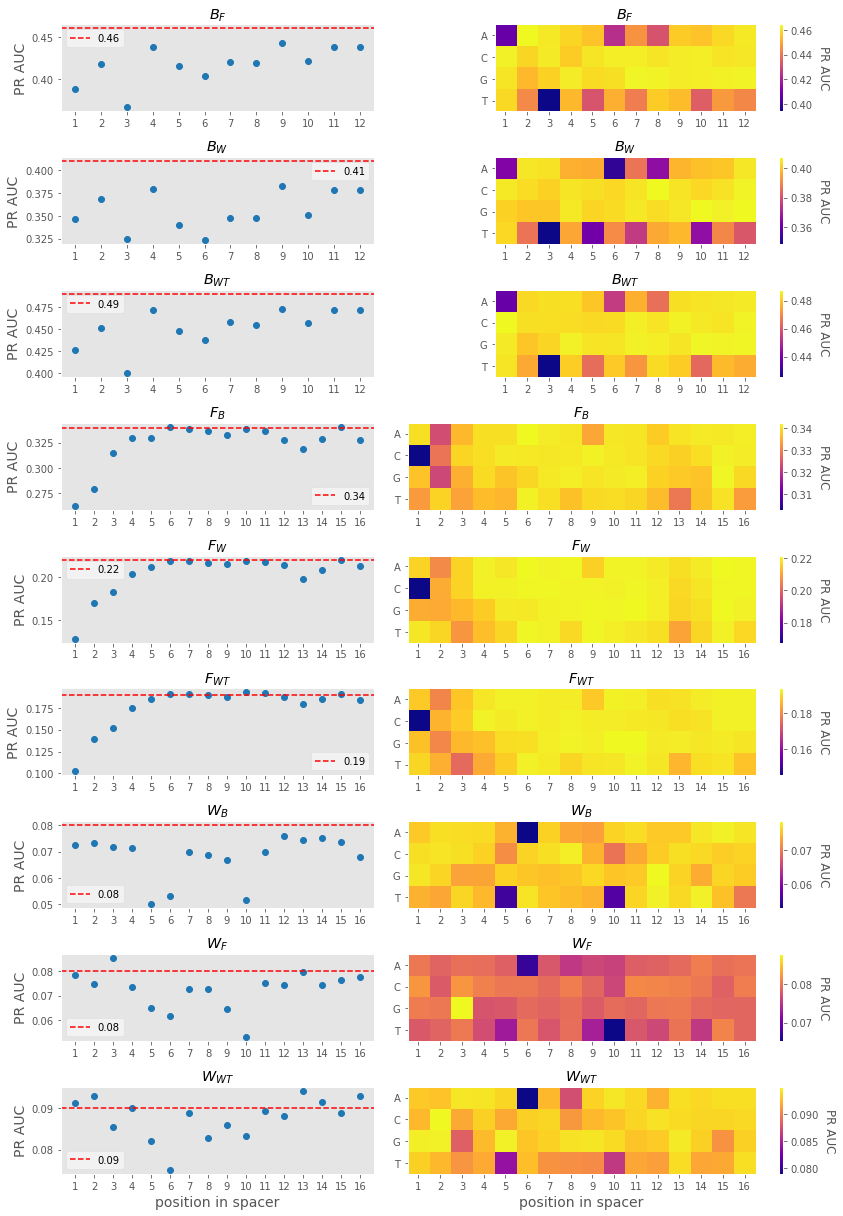

In [46]:
from matplotlib import gridspec

df_names = ['B_F', 'B_W', 'B_WT', 'F_B', 'F_W', 'F_WT', 'W_B', 'W_F', 'W_WT']
titles = ['$B_F$', '$B_W$', '$B_{WT}$', '$F_B$', '$F_W$', '$F_{WT}$', '$W_B$', '$W_F$', '$W_{WT}$']
best_pr_aucs = [0.46, 0.41, 0.49, 0.34, 0.22, 0.19, 0.08, 0.08, 0.09]
best_roc_aucs = [0.71, 0.71, 0.68, 0.67, 0.65, 0.65, 0.63, 0.65, 0.66]

# Prepare figure
fig = plt.figure(figsize=(12, 17))
gs = gridspec.GridSpec(nrows=9, ncols=2, width_ratios=[2, 3])
plt.style.use('ggplot') 

with torch.no_grad():
    
    #---------------------------------------#
    #         Left part of figure           #
    #---------------------------------------#
    
    print('making left part of figure...')
    
    # Iterate over all datasets and all the left axes
    for label_no, df_name in enumerate(df_names):
        
        # Prepare variables based on dataset 
        title = titles[label_no]
        best_roc_auc = best_roc_aucs[label_no]
        best_pr_auc = best_pr_aucs[label_no]
        
        print(df_name)
        
        if df_name in ['B_F', 'B_W', 'B_WT']:
            spacer_positions = (19, 31)        
        
        elif df_name in ['F_B', 'F_W', 'F_WT']:
            spacer_positions = (20, 36)
            
        elif df_name in ['W_B', 'W_F', 'W_WT']:
            spacer_positions = (17, 33)
            
        # Initiate dictionary
        occlusion_dict = dict()

        # Testing loop
        for (data, target) in dataloaders[f'test_label_{label_no}']:

            # Deflatten and convert to numpy array
            # Select correct target
            data = data.reshape(4, -1).cpu().data
            target = target.cpu().data.numpy()
            target = target[0][label_no]

            # Initialise list that contains the new probabilities
            # the index of the probability in the list coincides with the position
            # that was occluded in the nucleotide sequence
            output_list = list()

            # Loop over all positions in the sequence
            for j in range(spacer_positions[0], spacer_positions[1]):

                # Create a copy of the original one-hot sequence
                # Has to be done for every position to remove occlusion from previous positions
                data_occluded = np.copy(data)

                # Replace j-th column with all zeros (=occluded)
                data_occluded[:, j] = np.zeros(4)

                # Flatten again
                data_occluded = data_occluded.flatten()

                # Add batch dimension
                data_occluded = data_occluded[None, :]

                # Convert back to tensor and put on GPU
                data_occluded = torch.from_numpy(data_occluded).to(device, dtype=torch.float32)

                # Feed into model
                output = model(data_occluded)

                # Convert activations to probabilities with sigmoid and convert back to numpy array
                output = torch.sigmoid(output).data.cpu().numpy()

                # Select correct label
                output = output[0][label_no]

                # Add new output to list
                output_list.append(output)

            # Add target to output list
            output_list.append(target)
            
            # Convert one-hot sequence back to a regular DNA sequence
            seq = one_hot_sequence_to_DNA(data.cpu().numpy())

            # Add to dictionary
            occlusion_dict[seq] = output_list
            
        # Convert dictionary to dataframe
        outputs_df = pd.DataFrame.from_dict(occlusion_dict, orient='index')
        
        # Calculate PR AUC for each position
        pr_auc_list = list()
        
        for c in outputs_df.columns[:-1]:
            
            # Calculate PR AUC
            pr_auc = average_precision_score(outputs_df.iloc[:, -1].values, outputs_df.loc[:, c].values)
            pr_auc_list.append(pr_auc)
            
        # Samples are the reverse complement so to make conclusions about actual sequence,
        # it would be best to take the reverse complement. We cna therefore just reverse the positions
        pr_auc_list = pr_auc_list[::-1]

        # Plot PR AUC
        ax = fig.add_subplot(gs[label_no, 0])

        if label_no == 8:
            ax.set_xlabel('position in spacer', fontsize=14)
            
        ax.set_ylabel('PR AUC', fontsize=14)
        ax.set_xticks([i - spacer_positions[0] for i in range(spacer_positions[0], spacer_positions[1])])

        ax.plot(pr_auc_list, 'o', c='#1f77b4')
        ax.axhline(y=best_pr_auc, linestyle='--', c='r', label=best_pr_auc)        
        ax.set_xticklabels([i - spacer_positions[0] + 1 for i in range(spacer_positions[0], spacer_positions[1])])
        ax.grid(axis='both', b=False)
        ax.set_title(title)
        ax.legend(facecolor='white', framealpha=0.5)
         
    #---------------------------------------#
    #         Right part of figure          #
    #---------------------------------------# 
    
    print('making right part of figure...')

    # Iterate over all datasets and all the right axes
    for label_no, df_name in enumerate(df_names):
        
        print(df_name)
        title = titles[label_no]

        output_dict = dict()
                
        if df_name in ['B_F', 'B_W', 'B_WT']:
            spacer_positions = (19, 31)        
        
        elif df_name in ['F_B', 'F_W', 'F_WT']:
            spacer_positions = (20, 36)
            
        elif df_name in ['W_B', 'W_F', 'W_WT']:
            spacer_positions = (17, 33)

        # Initialise dictionaries that contains the new outputs,
        # as well as the coordinate of the exact value that was removed in the occluded sequence.
        # E.g. ACTG occluded at position 2 becomes A_TG. So the dictionaries
        # gets as key the coordinate (1, 1) because in a one-hot sequence
        # this represents a "C" at the second position. And as value it gets the output and label.
        # of all samples including the ones that were occluded.
        for x in range(0, 4):
            for y in range(spacer_positions[0], spacer_positions[1]):
                output_dict[(x, y)] = []

        # Testing loop
        for i, (data, target) in enumerate(dataloaders[f'test_label_{label_no}']):
            
            # Calculate unoccluded output
            unoccluded_output = torch.sigmoid(model(data)).data.cpu().numpy()[0][label_no]

            # Deflatten and convert to numpy array
            data = data.reshape(4, -1).cpu().data
            target = target.cpu().data.numpy()
            target = target[0][label_no]

            # Loop over all positions in the sequence
            for j in range(spacer_positions[0], spacer_positions[1]):

                # Create a copy of the original one-hot sequence
                # Has to be done for every position to remove occlusion from previous positions
                data_occluded = np.copy(data)

                # Replace j-th column with all zeros (=occluded)
                data_occluded[:, j] = np.zeros(4)

                # Flatten again
                data_occluded = data_occluded.flatten()

                # Add batch dimension
                data_occluded = data_occluded[None, :]

                # Convert back to tensor and put on GPU
                data_occluded = torch.from_numpy(data_occluded).to(device, dtype=torch.float32)

                # Feed into model
                output = model(data_occluded)

                # Convert activations to probabilities with sigmoid and convert back to numpy array
                output = torch.sigmoid(output).data.cpu().numpy()

                # Select correct label
                output = output[0][label_no]
                
                index_occluded_nucleotide = list(data[:, j].cpu().numpy()).index(1)  
                                
                all_nucleotide_indexes = [0, 1, 2, 3]
                all_nucleotide_indexes.remove(index_occluded_nucleotide)
                                                
                # Append output of unoccluded sample to dict for all nucleotides except the occluded one
                for idx in all_nucleotide_indexes:
                    output_dict[(idx, j)].append((unoccluded_output, target))
                    
                # Append output of occluded sample to dict for the occluded nucleotide
                output_dict[(index_occluded_nucleotide, j)].append((output, target))
                                
        pr_auc_mat = np.zeros((4, 50))

        for X, (k, v) in enumerate(output_dict.items()):

            if v:
                outputs = [i[0] for i in  v]
                targets = [j[1] for j in v]

                pr_auc = average_precision_score(targets, outputs)

            else:
                pr_auc = np.NaN

            pr_auc_mat[k[0]][k[1]] = pr_auc

        # Select only spacer sequence
        pr_auc_mat = pr_auc_mat[:, spacer_positions[0]:spacer_positions[1]]
        
        # Again we take reverse complement here
        # Reverse order of matrix
        pr_auc_mat = np.flip(pr_auc_mat, 1)
        
        # Switch A row with T row, and G row with C row
        pr_auc_mat[[0, 3]] = pr_auc_mat[[3, 0]]
        pr_auc_mat[[1, 2]] = pr_auc_mat[[2, 1]]
        
        ax = fig.add_subplot(gs[label_no, 1])
        ax.grid(axis='both', b=False)

        im = ax.imshow(pr_auc_mat, cmap='plasma')
        ax.set_xticks([i - spacer_positions[0] for i in range(spacer_positions[0], spacer_positions[1])])
        ax.set_xticklabels([i - spacer_positions[0] + 1 for i in range(spacer_positions[0], spacer_positions[1])])
        ax.set_yticklabels([0, 'A', 'C', 'G', 'T'])
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('PR AUC', rotation=-90, va="bottom")
        ax.set_title(title)
        
        if label_no == 8:
            ax.set_xlabel('position in spacer', fontsize=14)
            
        plt.tight_layout()
        
    plt.show()